In [1]:
import cv2,os,random,itertools,math,time,copy
from tqdm import tqdm_notebook as tqdm
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, TimeDistributed, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Conv2D
from keras.engine import Layer
import keras.backend as K
import tensorflow as tf
from keras import Model
from keras.optimizers import Adam
from keras.objectives import categorical_crossentropy
from keras.utils import generic_utils

Using TensorFlow backend.


In [3]:
input_path = "/home/vision/Documents/Rohit/RCNN/VOC2012"

In [4]:
all_imgs = []
classes_count = {}
class_mapping = {}

In [5]:
for di in tqdm(os.listdir(input_path)):
    annot_path = os.path.join(input_path, 'Annotations')
    imgs_path = os.path.join(input_path, 'JPEGImages')
    imgsets_path_trainval = os.path.join(input_path, 'ImageSets', 'Main', 'trainval.txt')
    imgsets_path_train = os.path.join(input_path, 'ImageSets', 'Main', 'train.txt')
    imgsets_path_val = os.path.join(input_path, 'ImageSets', 'Main', 'val.txt')
    trainval_files = []
    train_files = []
    val_files = []
    with open(imgsets_path_trainval) as f:
        for line in f:
            trainval_files.append(line.strip() + '.jpg')
    with open(imgsets_path_train) as f:
        for line in f:
            train_files.append(line.strip() + '.jpg')
    with open(imgsets_path_val) as f:
        for line in f:
            val_files.append(line.strip() + '.jpg')
    idx = 0
    for ann in os.listdir(annot_path):
        exist_flag = False
        idx += 1
        et = ET.parse(os.path.join(annot_path,ann))
        element = et.getroot()
        element_objs = element.findall('object')
        element_filename = element.find('filename').text
        element_width = int(element.find('size').find('width').text)
        element_height = int(element.find('size').find('height').text)
        if len(element_objs) > 0:
            annotation_data = {'filepath': os.path.join(imgs_path, element_filename), 'width': element_width,
                               'height': element_height, 'bboxes': []}

            annotation_data['image_id'] = idx

            if element_filename in trainval_files:
                annotation_data['imageset'] = 'trainval'
                exist_flag = True

            if element_filename in train_files:
                annotation_data['imageset'] = 'train'
                exist_flag = True
                
            if element_filename in val_files:
                annotation_data['imageset'] = 'val'
                exist_flag = True
                
        if not exist_flag:
                continue
                
        for element_obj in element_objs:
            class_name = element_obj.find('name').text
            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                class_mapping[class_name] = len(class_mapping)
                
            obj_bbox = element_obj.find('bndbox')
            x1 = int(round(float(obj_bbox.find('xmin').text)))
            y1 = int(round(float(obj_bbox.find('ymin').text)))
            x2 = int(round(float(obj_bbox.find('xmax').text)))
            y2 = int(round(float(obj_bbox.find('ymax').text)))
            difficulty = int(element_obj.find('difficult').text) == 1
            annotation_data['bboxes'].append(
                {'class': class_name, 'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'difficult': difficulty})
        all_imgs.append(annotation_data)

In [6]:
class_mapping

{'tvmonitor': 0,
 'train': 1,
 'person': 2,
 'boat': 3,
 'horse': 4,
 'cow': 5,
 'bottle': 6,
 'dog': 7,
 'aeroplane': 8,
 'car': 9,
 'bus': 10,
 'bicycle': 11,
 'chair': 12,
 'diningtable': 13,
 'pottedplant': 14,
 'bird': 15,
 'cat': 16,
 'motorbike': 17,
 'sheep': 18,
 'sofa': 19}

In [7]:
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

In [8]:
inv_map = {v: k for k, v in class_mapping.items()}

In [9]:
inv_map

{0: 'tvmonitor',
 1: 'train',
 2: 'person',
 3: 'boat',
 4: 'horse',
 5: 'cow',
 6: 'bottle',
 7: 'dog',
 8: 'aeroplane',
 9: 'car',
 10: 'bus',
 11: 'bicycle',
 12: 'chair',
 13: 'diningtable',
 14: 'pottedplant',
 15: 'bird',
 16: 'cat',
 17: 'motorbike',
 18: 'sheep',
 19: 'sofa',
 20: 'bg'}

In [10]:
random.shuffle(all_imgs)

In [11]:
train_imgs = [s for s in all_imgs if s['imageset'] == 'train']
val_imgs = [s for s in all_imgs if s['imageset'] == 'val']

In [12]:
# data_gen_train = data_generators.get_anchor_gt(train_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='train')
# data_gen_val = data_generators.get_anchor_gt(val_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='val')
# data_gen_test = data_generators.get_anchor_gt(test_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='val')

In [13]:
train_imgs

[{'filepath': '/home/vision/Documents/Rohit/RCNN/VOC2012/JPEGImages/2008_002062.jpg',
  'width': 500,
  'height': 333,
  'bboxes': [{'class': 'car',
    'x1': 1,
    'x2': 404,
    'y1': 20,
    'y2': 331,
    'difficult': False},
   {'class': 'car',
    'x1': 220,
    'x2': 473,
    'y1': 1,
    'y2': 83,
    'difficult': False}],
  'image_id': 1778,
  'imageset': 'train'},
 {'filepath': '/home/vision/Documents/Rohit/RCNN/VOC2012/JPEGImages/2009_004756.jpg',
  'width': 500,
  'height': 459,
  'bboxes': [{'class': 'person',
    'x1': 107,
    'x2': 376,
    'y1': 12,
    'y2': 459,
    'difficult': False},
   {'class': 'motorbike',
    'x1': 3,
    'x2': 483,
    'y1': 207,
    'y2': 459,
    'difficult': False}],
  'image_id': 7533,
  'imageset': 'train'},
 {'filepath': '/home/vision/Documents/Rohit/RCNN/VOC2012/JPEGImages/2008_007897.jpg',
  'width': 500,
  'height': 432,
  'bboxes': [{'class': 'horse',
    'x1': 279,
    'x2': 404,
    'y1': 141,
    'y2': 387,
    'difficult': Fals

In [14]:
def get_new_img_size(width, height, img_min_side=300):
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = int(img_min_side)
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = int(img_min_side)

    return resized_width, resized_height

In [15]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [16]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4


def rpn_loss_regr(num_anchors):
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    def rpn_loss_cls_fixed_num(y_true, y_pred):
        return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))


In [18]:
def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X

In [19]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300): 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

In [20]:
def calc_iou(R, img_data, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, 300)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < 0.1:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if 0.1 <= best_iou < 0.5:
                # hard negative example
                cls_name = 'bg'
            elif 0.5 <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = [8.0, 8.0, 4.0, 4.0] #classifier regression standard
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [21]:
def base_model_layers(img_input):
    #         VGG16 implementation
        # Block 1
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

        # Block 2
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

        # Block 3
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

        # Block 4
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

        # Block 5
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
        return x

In [22]:
def rpn(base_layers,num_anchors):
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_class,x_regr,base_layers]

In [23]:
def classifier(base_layers,roi_input, num_rois, classes = 21):
    pooling_regions = 7
    input_shape = (num_rois, 7, 7, 512)
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, roi_input])
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out_class = TimeDistributed(Dense(classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(classes))(out)
    return [out_class,out_regr]

In [24]:
img_channel_mean = [103.939, 116.779, 123.68]
standard_scaling = 4.0
rpn_stride = 16
num_rois = 4
anchor_sizes = [64, 128, 256]   # 128, 256, 512
anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

In [25]:
input_shape_img = (None, None, 3)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))
#         shared layers VGG16
base_layer = base_model_layers(img_input)
#RPN
num_anchors = 9
rpnetwork = rpn(base_layer,num_anchors)
#         classifier layer 
classnetwork = classifier(base_layer,roi_input,num_rois,len(classes_count))
model_rpn = Model(img_input, rpnetwork[:2])
model_classifier = Model([img_input, roi_input], classnetwork)
model_all = Model([img_input, roi_input], rpnetwork[:2] + classnetwork)
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [26]:
model_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [27]:
def datagen(train_imgs):
    while True:
        for timages in train_imgs:
            try:
                img = cv2.imread(timages['filepath'])
                x_img = img.copy()
                (height, width,_) = x_img.shape
                resized_width, resized_height = get_new_img_size(width,height)
                x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
            #     calculate rpn
                try:
                    downscale = float(rpn_stride) 
                    anchor_sizes = [64, 128, 256]   # 128, 256, 512
                    anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
                    num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

                    out_width, out_height = resized_width//16 , resized_height//16
                    num_anchor_ratio = len(anchor_ratios) 

                    y_rpn_overlap = np.zeros((out_height, out_width, num_anchors))
                    y_is_box_valid = np.zeros((out_height, out_width, num_anchors))
                    y_rpn_regr = np.zeros((out_height, out_width, num_anchors * 4))
                    num_bboxes = len(timages['bboxes'])

                    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
                    best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
                    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
                    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
                    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)
                    gta = np.zeros((num_bboxes, 4))
            #         print(best_iou_for_bbox)
                    for bbox_num, bbox in enumerate(timages['bboxes']):
                        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
                        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
                        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
                        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
                #         cv2.rectangle(img,(bbox['x1'],bbox['y1']),(bbox['x2'],bbox['y2']),(255,0,0), 2)
                #         cv2.rectangle(x_img,(int(89*(357/500)),int(129*(357/500))),(int(486*(300/420)),int(351*(300/420))),(255,0,0), 2)
                #         ***********rpn ground truth bobox
                    for anchorsize_idx in range(len(anchor_sizes)):
                        for anchor_ratio_idx in range(num_anchor_ratio):
                            anchor_x = anchor_sizes[anchorsize_idx] * anchor_ratios[anchor_ratio_idx][0]
                            anchor_y = anchor_sizes[anchorsize_idx] * anchor_ratios[anchor_ratio_idx][1]
                            for ixw in range(out_width):
                                x1_anc = downscale * (ixw + 0.5) - anchor_x / 2
                                x2_anc = downscale * (ixw + 0.5) + anchor_x / 2

                                if x1_anc < 0 or x2_anc > resized_width:
                                    continue

                                for jy in range(out_width):
                                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                                    if y1_anc < 0 or y2_anc > resized_height:
                                        continue

                                    bbox_type = 'neg'
                                    best_iou_for_loc = 0.0

                                    for bbox_num in range(num_bboxes):
                                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
                #                         print(curr_iou,best_iou_for_bbox[bbox_num])
                                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > 0.7:
                                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                                            cxa = (x1_anc + x2_anc)/2.0
                                            cya = (y1_anc + y2_anc)/2.0

                                            tx = (cx - cxa) / (x2_anc - x1_anc)
                                            ty = (cy - cya) / (y2_anc - y1_anc)
                                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                                        if timages['bboxes'][bbox_num]['class'] != 'bg':
                                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                                best_anchor_for_bbox[bbox_num] = [jy, ixw, anchor_ratio_idx, anchorsize_idx]
                                                best_iou_for_bbox[bbox_num] = curr_iou
                                                best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                                best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]
                                            if curr_iou > 0.7:
                                                bbox_type = 'pos'
                                                num_anchors_for_bbox[bbox_num] += 1
                #                                 regressor
                                            if curr_iou > best_iou_for_loc:
                                                best_iou_for_loc = curr_iou
                                                best_regr = (tx, ty, tw, th)
                                            if 0.3 < curr_iou < 0.7:
                                                if bbox_type != 'pos':
                                                    bbox_type = 'neutral'

                                    if bbox_type == 'neg':
                                        y_is_box_valid[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 1
                                        y_rpn_overlap[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 0
                                    elif bbox_type == 'neutral':
                                        y_is_box_valid[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 0
                                        y_rpn_overlap[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 0
                                    elif bbox_type == 'pos':
                                        y_is_box_valid[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 1
                                        y_rpn_overlap[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 1
                                        start = 4 * (anchor_ratio_idx + num_anchor_ratio * anchorsize_idx)
                                        y_rpn_regr[jy, ixw, start:start+4] = best_regr
                #         print("y_rpn_overlap ",y_rpn_overlap," y_is_box_valid ",y_is_box_valid," y_rpn_regr ",y_rpn_regr)
                    for idx in range(num_anchors_for_bbox.shape[0]):
                        if num_anchors_for_bbox[idx] == 0:
                            # no box with an IOU greater than zero ...
                            if best_anchor_for_bbox[idx, 0] == -1:
                                continue
                            y_is_box_valid[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + num_anchor_ratio *best_anchor_for_bbox[idx,3]] = 1
                            y_rpn_overlap[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + num_anchor_ratio *best_anchor_for_bbox[idx,3]] = 1
                            start = 4 * (best_anchor_for_bbox[idx,2] + num_anchor_ratio * best_anchor_for_bbox[idx,3])
                            y_rpn_regr[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]
                    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
                    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

                    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
                    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

                    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
                    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

                    pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
                    neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

                    num_pos = len(pos_locs[0])
                #     set limit
                    num_regions = 256

                    if len(pos_locs[0]) > num_regions/2:
                        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
                        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
                        num_pos = num_regions/2

                    if len(neg_locs[0]) + num_pos > num_regions:
                        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
                        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

                    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
                    y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)
                except Exception as e:
                    print(e)
            #     processing image
                x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
                x_img = x_img.astype(np.float32)
                x_img[:, :, 0] -= img_channel_mean[0]
                x_img[:, :, 1] -= img_channel_mean[1]
                x_img[:, :, 2] -= img_channel_mean[2]
                x_img /= 1.0 #image scaling factor set to 1.0

                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)
                y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= standard_scaling # standard scaling set to 4.0
                x_img = np.transpose(x_img, (0, 2, 3, 1))
                y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
                y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))
                yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], timages
            except  Exception as e:
                print(e)
                continue

In [28]:
data = datagen(train_imgs)

In [29]:
print(data)

<generator object datagen at 0x7fec90ac4a98>


In [30]:
epoch_length = 10
num_epochs = 2000 #NUMBER OF EPOCH
iter_num = 0 
train_step = 0
losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()
best_loss = np.Inf
print("*** started training ***")
for epoch in range(num_epochs):
    progbar = generic_utils.Progbar(epoch_length)
    print("Epoch {}/{}".format(epoch+1,num_epochs))
    while True:
#         try:
            X1,Y1,timages = next(data)
#             print(len(Y1))
            loss_rpn = model_rpn.train_on_batch(X1,Y1)
            P_rpn = model_rpn.predict_on_batch(X1)
            regr_layer = P_rpn[1] / standard_scaling
            (rpnrows, rpncols) = P_rpn[0].shape[1:3]
            curr_layer = 0
            A = np.zeros((4, P_rpn[0].shape[1], P_rpn[0].shape[2], P_rpn[0].shape[3]))
        #                     A will be of size (4,feature_map_height,feature_map_width,num_anchors) 4 for coordinates num_anchor is 9
            for anchor_size in anchor_sizes:
                for anchor_ratio in anchor_ratios:
                    anchor_x = (anchor_size * anchor_ratio[0])/rpn_stride
                    anchor_y = (anchor_size * anchor_ratio[1])/rpn_stride
                    regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
                    regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)
                    X, Y = np.meshgrid(np.arange(rpncols),np.arange(rpnrows))
                    A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
                    A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
                    A[2, :, :, curr_layer] = anchor_x       # width of current anchor
                    A[3, :, :, curr_layer] = anchor_y       # height of current anchor
                    A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)
                    # Avoid width and height to exceed 1
                    A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
                    A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
        #                             convert x ,y, w, h to x1 ,y1 ,x2, y2
                    A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
                    A[3, :, :, curr_layer] += A[1, :, :, curr_layer]
                    A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
                    A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
                    A[2, :, :, curr_layer] = np.minimum(rpncols-1, A[2, :, :, curr_layer])
                    A[3, :, :, curr_layer] = np.minimum(rpnrows-1, A[3, :, :, curr_layer])
                    curr_layer += 1
            all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))
            all_probs = P_rpn[0].transpose((0, 3, 1, 2)).reshape((-1))
            x1 = all_boxes[:, 0]
            y1 = all_boxes[:, 1]
            x2 = all_boxes[:, 2]
            y2 = all_boxes[:, 3]
        #                     delete wrong bounding box
            idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
            all_boxes = np.delete(all_boxes, idxs, 0)
            all_probs = np.delete(all_probs, idxs, 0)
            result = non_max_suppression_fast(all_boxes, all_probs)[0]
            X2, Y1, Y2, IouS = calc_iou(result, timages, class_mapping)
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))
            if num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, num_rois//2, replace=False).tolist()

                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples), replace=True).tolist()

                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)
#             print(X)
            loss_class = model_classifier.train_on_batch([X1, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1
        #                         print(losses)
            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])), ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                print('Loss RPN regression: {}'.format(loss_rpn_regr))
                print('Loss Detector classifier: {}'.format(loss_class_cls))
                print('Loss Detector regression: {}'.format(loss_class_regr))
                print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                print('Elapsed time: {}'.format(time.time() - start_time))
                elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(os.path.join('/home/vision/Documents/Rohit/FasterRCNN/model_frcnn_vgg.hdf5'))
                break

#         except Exception as e:
#             print("training error {}".format(e))
#             continue   
    
#     break
    
print("Training completed")

*** started training ***
Epoch 1/2000
10/10 [==============================] - 11s 1s/step - rpn_cls: 6.4890 - rpn_regr: 0.2181 - final_cls: 3.0235 - final_regr: 0.5417
Mean number of bounding boxes from RPN overlapping ground truth boxes: 26.6
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 7.0013768672943115
Loss RPN regression: 0.2483350459486246
Loss Detector classifier: 2.9656734704971313
Loss Detector regression: 0.36830347776412964
Total loss: 10.583688861504196
Elapsed time: 11.417674779891968
Total loss decreased from inf to 10.583688861504196, saving weights
Epoch 2/2000
10/10 [==============================] - 3s 307ms/step - rpn_cls: 6.3177 - rpn_regr: 0.1513 - final_cls: 2.6234 - final_regr: 0.3089
Mean number of bounding boxes from RPN overlapping ground truth boxes: 31.0
Classifier accuracy for bounding boxes from RPN: 0.625
Loss RPN classifier: 6.276802391401725
Loss RPN regression: 0.1340142256580293
Loss Detector classifier: 2.503737115859985

10/10 [==============================] - 3s 335ms/step - rpn_cls: 2.3080 - rpn_regr: 0.3375 - final_cls: 2.3454 - final_regr: 0.4707
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 2.4042672951705755
Loss RPN regression: 0.32217062562704085
Loss Detector classifier: 2.259877610206604
Loss Detector regression: 0.4879766970872879
Total loss: 5.474292228091508
Elapsed time: 3.3455889225006104
Epoch 18/2000
10/10 [==============================] - 3s 295ms/step - rpn_cls: 2.7427 - rpn_regr: 0.1869 - final_cls: 2.3281 - final_regr: 0.4153
Mean number of bounding boxes from RPN overlapping ground truth boxes: 36.4
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 2.9323148586874597
Loss RPN regression: 0.1985314480960369
Loss Detector classifier: 2.1594467163085938
Loss Detector regression: 0.36605994775891304
Total loss: 5.656352970851003
Elapsed time: 2.954695463180

10/10 [==============================] - 3s 298ms/step - rpn_cls: 2.6275 - rpn_regr: 0.1209 - final_cls: 2.2631 - final_regr: 0.3854
Mean number of bounding boxes from RPN overlapping ground truth boxes: 60.6
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 2.476834317009525
Loss RPN regression: 0.13332839570939542
Loss Detector classifier: 2.2810879349708557
Loss Detector regression: 0.41440551951527593
Total loss: 5.305656167205052
Elapsed time: 2.976301908493042
Epoch 50/2000
10/10 [==============================] - 3s 272ms/step - rpn_cls: 2.5519 - rpn_regr: 0.2325 - final_cls: 1.9445 - final_regr: 0.4565
Mean number of bounding boxes from RPN overlapping ground truth boxes: 43.9
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 3.577424139995128
Loss RPN regression: 0.3416776265949011
Loss Detector classifier: 1.9328722834587098
Loss Detector regression: 0.5122768729925156
Total loss: 6.364250923041254
Elapsed time: 2.71657395362854

10/10 [==============================] - 3s 271ms/step - rpn_cls: 3.0225 - rpn_regr: 0.3256 - final_cls: 1.5488 - final_regr: 0.3952
Mean number of bounding boxes from RPN overlapping ground truth boxes: 35.333333333333336
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 2.8244767021387815
Loss RPN regression: 0.3124079018831253
Loss Detector classifier: 1.486870241165161
Loss Detector regression: 0.32015193104743955
Total loss: 4.943906776234507
Elapsed time: 2.7069756984710693
Epoch 66/2000
10/10 [==============================] - 3s 254ms/step - rpn_cls: 1.8858 - rpn_regr: 0.2427 - final_cls: 2.1791 - final_regr: 0.4797
Mean number of bounding boxes from RPN overlapping ground truth boxes: 53.2
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 3.9994740246655054
Loss RPN regression: 0.41820850148797034
Loss Detector classifier: 1.7713744014501571
Loss Detector regression: 0.31973530650138854
Total loss: 6.508792234105021
Elapsed time:

10/10 [==============================] - 3s 271ms/step - rpn_cls: 2.8674 - rpn_regr: 0.2459 - final_cls: 1.9851 - final_regr: 0.5598
Mean number of bounding boxes from RPN overlapping ground truth boxes: 39.0
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.539653164811898
Loss RPN regression: 0.2239243434742093
Loss Detector classifier: 1.7616098284721375
Loss Detector regression: 0.4933694124221802
Total loss: 6.0185567491804255
Elapsed time: 2.708188533782959
Epoch 82/2000
10/10 [==============================] - 2s 241ms/step - rpn_cls: 5.5086 - rpn_regr: 0.5968 - final_cls: 1.7254 - final_regr: 0.3087
Mean number of bounding boxes from RPN overlapping ground truth boxes: 45.8
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.6665032726472417
Loss RPN regression: 0.47886868454515935
Loss Detector classifier: 1.971496856212616
Loss Detector regression: 0.34413916915655135
Total loss: 6.461007982561568
Elapsed time: 2.409054279327

10/10 [==============================] - 3s 306ms/step - rpn_cls: 5.5077 - rpn_regr: 0.3854 - final_cls: 1.4335 - final_regr: 0.1761
Mean number of bounding boxes from RPN overlapping ground truth boxes: 50.0
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.696467541973107
Loss RPN regression: 0.27487500086426736
Loss Detector classifier: 1.6738903999328614
Loss Detector regression: 0.3068467602133751
Total loss: 6.95207970298361
Elapsed time: 3.0651321411132812
Epoch 98/2000
10/10 [==============================] - 2s 245ms/step - rpn_cls: 7.5638 - rpn_regr: 0.4701 - final_cls: 1.3344 - final_regr: 0.2350
Mean number of bounding boxes from RPN overlapping ground truth boxes: 31.2
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 5.80693200037058
Loss RPN regression: 0.33273572362959386
Loss Detector classifier: 1.7975521445274354
Loss Detector regression: 0.3183367639780045
Total loss: 8.255556632505614
Elapsed time: 2.4532635211944

10/10 [==============================] - 4s 356ms/step - rpn_cls: 4.5726 - rpn_regr: 0.3902 - final_cls: 1.6650 - final_regr: 0.4196
Mean number of bounding boxes from RPN overlapping ground truth boxes: 26.923076923076923
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 5.454407036304474
Loss RPN regression: 0.3833683878183365
Loss Detector classifier: 1.5037254810333252
Loss Detector regression: 0.30938036143779757
Total loss: 7.650881266593934
Elapsed time: 3.5576119422912598
Epoch 114/2000
10/10 [==============================] - 2s 239ms/step - rpn_cls: 2.8859 - rpn_regr: 0.1484 - final_cls: 1.6326 - final_regr: 0.3384
Mean number of bounding boxes from RPN overlapping ground truth boxes: 51.8
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.2521242596975752
Loss RPN regression: 0.1742321766912937
Loss Detector classifier: 1.8240117609500885
Loss Detector regression: 0.3311243176460266
Total loss: 5.581492514984984
Elapsed time:

10/10 [==============================] - 3s 263ms/step - rpn_cls: 2.7937 - rpn_regr: 0.2249 - final_cls: 2.0011 - final_regr: 0.5234
Mean number of bounding boxes from RPN overlapping ground truth boxes: 23.545454545454547
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.598794259969145
Loss RPN regression: 0.4286338251084089
Loss Detector classifier: 1.9727102756500243
Loss Detector regression: 0.504357847571373
Total loss: 6.504496208298952
Elapsed time: 2.6340038776397705
Epoch 130/2000
10/10 [==============================] - 3s 283ms/step - rpn_cls: 2.1064 - rpn_regr: 0.1240 - final_cls: 2.0255 - final_regr: 0.3463
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.63636363636363
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.2795614076199855
Loss RPN regression: 0.20269627925008535
Loss Detector classifier: 1.6960493683815003
Loss Detector regression: 0.281366103887558
Total loss: 5.459673159139129
El

10/10 [==============================] - 2s 237ms/step - rpn_cls: 4.3596 - rpn_regr: 0.2301 - final_cls: 1.8274 - final_regr: 0.3012
Mean number of bounding boxes from RPN overlapping ground truth boxes: 44.8
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.119997791268543
Loss RPN regression: 0.20764388255774974
Loss Detector classifier: 1.8332769274711609
Loss Detector regression: 0.3612535774707794
Total loss: 5.5221721787682325
Elapsed time: 2.3670785427093506
Epoch 146/2000
10/10 [==============================] - 3s 268ms/step - rpn_cls: 3.0780 - rpn_regr: 0.3375 - final_cls: 2.0212 - final_regr: 0.4778
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.09090909090909
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 4.065316784850529
Loss RPN regression: 0.39440729320049284
Loss Detector classifier: 1.8810036122798919
Loss Detector regression: 0.41979862153530123
Total loss: 6.760526311866215
Elapsed time

10/10 [==============================] - 3s 252ms/step - rpn_cls: 6.8787 - rpn_regr: 0.2180 - final_cls: 1.9459 - final_regr: 0.4335
Mean number of bounding boxes from RPN overlapping ground truth boxes: 25.818181818181817
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 6.751688885688782
Loss RPN regression: 0.34483128860592843
Loss Detector classifier: 1.7749082088470458
Loss Detector regression: 0.37953522652387617
Total loss: 9.250963609665632
Elapsed time: 2.517915725708008
Epoch 162/2000
10/10 [==============================] - 2s 238ms/step - rpn_cls: 1.1239 - rpn_regr: 0.2478 - final_cls: 1.9293 - final_regr: 0.5253
Mean number of bounding boxes from RPN overlapping ground truth boxes: 51.0
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 2.357161860150518
Loss RPN regression: 0.324166839197278
Loss Detector classifier: 1.819886040687561
Loss Detector regression: 0.3983901858329773
Total loss: 4.899604925868334
Elapsed time: 2.

10/10 [==============================] - 2s 236ms/step - rpn_cls: 2.0888 - rpn_regr: 0.1827 - final_cls: 2.0361 - final_regr: 0.3008
Mean number of bounding boxes from RPN overlapping ground truth boxes: 44.3
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.11037011352455
Loss RPN regression: 0.22448539212346078
Loss Detector classifier: 1.8550871014595032
Loss Detector regression: 0.24050028026103973
Total loss: 6.430442887368554
Elapsed time: 2.3597607612609863
Epoch 178/2000
10/10 [==============================] - 2s 249ms/step - rpn_cls: 3.0926 - rpn_regr: 0.2407 - final_cls: 1.7838 - final_regr: 0.4567
Mean number of bounding boxes from RPN overlapping ground truth boxes: 50.0
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.859585452545434
Loss RPN regression: 0.3968711135908961
Loss Detector classifier: 1.562502697110176
Loss Detector regression: 0.330757637321949
Total loss: 6.149716900568455
Elapsed time: 2.4902172088623

10/10 [==============================] - 2s 239ms/step - rpn_cls: 2.5996 - rpn_regr: 0.2711 - final_cls: 1.9691 - final_regr: 0.4686
Mean number of bounding boxes from RPN overlapping ground truth boxes: 54.6
Classifier accuracy for bounding boxes from RPN: 0.525
Loss RPN classifier: 3.211063803372963
Loss RPN regression: 0.24285682439804077
Loss Detector classifier: 1.9481077909469604
Loss Detector regression: 0.4760937675833702
Total loss: 5.878122186301334
Elapsed time: 2.387683391571045
Epoch 194/2000
10/10 [==============================] - 3s 252ms/step - rpn_cls: 3.9692 - rpn_regr: 0.1853 - final_cls: 1.8096 - final_regr: 0.3321
Mean number of bounding boxes from RPN overlapping ground truth boxes: 44.0
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 2.119383184905746
Loss RPN regression: 0.19354598615318536
Loss Detector classifier: 1.9190632343292235
Loss Detector regression: 0.38900120854377745
Total loss: 4.620993613931932
Elapsed time: 2.5212409496

10/10 [==============================] - 2s 246ms/step - rpn_cls: 5.7698 - rpn_regr: 0.2108 - final_cls: 1.6049 - final_regr: 0.2428
Mean number of bounding boxes from RPN overlapping ground truth boxes: 26.8
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 5.607158413798652
Loss RPN regression: 0.28840244114398955
Loss Detector classifier: 1.5345892757177353
Loss Detector regression: 0.2577556729316711
Total loss: 7.687905803592048
Elapsed time: 2.4618375301361084
Epoch 210/2000
10/10 [==============================] - 3s 272ms/step - rpn_cls: 4.0787 - rpn_regr: 0.2290 - final_cls: 1.3167 - final_regr: 0.2507
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.72727272727273
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 5.216483414739196
Loss RPN regression: 0.2971989754587412
Loss Detector classifier: 1.5142888695001602
Loss Detector regression: 0.323082035779953
Total loss: 7.35105329547805
Elapsed time: 2.7

10/10 [==============================] - 3s 252ms/step - rpn_cls: 6.5469 - rpn_regr: 0.3799 - final_cls: 0.9181 - final_regr: 0.1003
Mean number of bounding boxes from RPN overlapping ground truth boxes: 19.8
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 5.267020462076471
Loss RPN regression: 0.24974691811949015
Loss Detector classifier: 1.3564329653978349
Loss Detector regression: 0.19087986946105956
Total loss: 7.064080215054855
Elapsed time: 2.5253448486328125
Epoch 226/2000
10/10 [==============================] - 2s 241ms/step - rpn_cls: 6.0663 - rpn_regr: 0.2452 - final_cls: 1.2091 - final_regr: 0.1889
Mean number of bounding boxes from RPN overlapping ground truth boxes: 31.2
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 6.202100935495127
Loss RPN regression: 0.2823431521654129
Loss Detector classifier: 1.478982138633728
Loss Detector regression: 0.25818603932857515
Total loss: 8.221612265622843
Elapsed time: 2.4151220321

10/10 [==============================] - 3s 324ms/step - rpn_cls: 5.2095 - rpn_regr: 0.3283 - final_cls: 1.6513 - final_regr: 0.3586
Mean number of bounding boxes from RPN overlapping ground truth boxes: 34.5
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 5.594102126016514
Loss RPN regression: 0.4214393192902207
Loss Detector classifier: 1.467696765065193
Loss Detector regression: 0.2918201476335526
Total loss: 7.775058358005481
Elapsed time: 3.2418723106384277
Epoch 242/2000
10/10 [==============================] - 2s 240ms/step - rpn_cls: 1.2408 - rpn_regr: 0.2487 - final_cls: 2.0211 - final_regr: 0.3924
Mean number of bounding boxes from RPN overlapping ground truth boxes: 53.5
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.9388975051180752
Loss RPN regression: 0.3280446190387011
Loss Detector classifier: 1.9293429851531982
Loss Detector regression: 0.3319615051150322
Total loss: 5.528246614425006
Elapsed time: 2.4004120826721

10/10 [==============================] - 3s 283ms/step - rpn_cls: 2.3691 - rpn_regr: 0.2870 - final_cls: 1.9235 - final_regr: 0.3908
Mean number of bounding boxes from RPN overlapping ground truth boxes: 43.3
Classifier accuracy for bounding boxes from RPN: 0.675
Loss RPN classifier: 2.8772443572743214
Loss RPN regression: 0.3487549651414156
Loss Detector classifier: 1.7710979282855988
Loss Detector regression: 0.3137005537748337
Total loss: 5.310797804476169
Elapsed time: 2.830512523651123
Epoch 258/2000
10/10 [==============================] - 3s 272ms/step - rpn_cls: 6.5178 - rpn_regr: 0.4380 - final_cls: 1.8221 - final_regr: 0.3352
Mean number of bounding boxes from RPN overlapping ground truth boxes: 26.272727272727273
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 6.345440049143508
Loss RPN regression: 0.7618753463029861
Loss Detector classifier: 1.4379607126116754
Loss Detector regression: 0.2875223129987717
Total loss: 8.83279842105694
Elapsed time: 2

10/10 [==============================] - 2s 247ms/step - rpn_cls: 6.9026 - rpn_regr: 0.3901 - final_cls: 2.2938 - final_regr: 0.4641
Mean number of bounding boxes from RPN overlapping ground truth boxes: 58.7
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 5.950553220557049
Loss RPN regression: 0.3260049492120743
Loss Detector classifier: 1.9887269377708434
Loss Detector regression: 0.42556646168231965
Total loss: 8.690851569222286
Elapsed time: 2.4748988151550293
Epoch 274/2000
10/10 [==============================] - 2s 239ms/step - rpn_cls: 4.1979 - rpn_regr: 0.3405 - final_cls: 1.4758 - final_regr: 0.2610
Mean number of bounding boxes from RPN overlapping ground truth boxes: 54.6
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 2.832008412167423
Loss RPN regression: 0.31410411968827245
Loss Detector classifier: 1.8276449263095855
Loss Detector regression: 0.3696157544851303
Total loss: 5.343373212650411
Elapsed time: 2.388417482376

10/10 [==============================] - 3s 262ms/step - rpn_cls: 2.5929 - rpn_regr: 0.2659 - final_cls: 1.7200 - final_regr: 0.3997
Mean number of bounding boxes from RPN overlapping ground truth boxes: 64.2
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.0841260658460667
Loss RPN regression: 0.2864090405404568
Loss Detector classifier: 1.8861936509609223
Loss Detector regression: 0.3584410771727562
Total loss: 5.615169834520202
Elapsed time: 2.6176459789276123
Epoch 290/2000
10/10 [==============================] - 3s 273ms/step - rpn_cls: 5.2372 - rpn_regr: 0.5156 - final_cls: 1.3098 - final_regr: 0.1744
Mean number of bounding boxes from RPN overlapping ground truth boxes: 41.25
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.8080601634137565
Loss RPN regression: 0.35265217050909997
Loss Detector classifier: 1.4679838478565217
Loss Detector regression: 0.2913735404610634
Total loss: 5.920069722240442
Elapsed time: 2.733447790

10/10 [==============================] - 2s 231ms/step - rpn_cls: 6.1065 - rpn_regr: 0.2599 - final_cls: 2.1547 - final_regr: 0.1867
Mean number of bounding boxes from RPN overlapping ground truth boxes: 21.3
Classifier accuracy for bounding boxes from RPN: 0.8
Loss RPN classifier: 6.1050528586623845
Loss RPN regression: 0.27800102196633814
Loss Detector classifier: 1.62856322824955
Loss Detector regression: 0.1714402824640274
Total loss: 8.1830573913423
Elapsed time: 2.30792236328125
Epoch 306/2000
10/10 [==============================] - 3s 258ms/step - rpn_cls: 1.9263 - rpn_regr: 0.1766 - final_cls: 1.9370 - final_regr: 0.3999
Mean number of bounding boxes from RPN overlapping ground truth boxes: 62.63636363636363
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 2.112189751713595
Loss RPN regression: 0.33004836924374104
Loss Detector classifier: 2.139370155334473
Loss Detector regression: 0.39786772429943085
Total loss: 4.979476000591239
Elapsed time: 2.5779

10/10 [==============================] - 2s 235ms/step - rpn_cls: 0.6097 - rpn_regr: 0.1831 - final_cls: 1.9157 - final_regr: 0.4645
Mean number of bounding boxes from RPN overlapping ground truth boxes: 66.5
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 1.3054808980944628
Loss RPN regression: 0.17519119717180728
Loss Detector classifier: 2.0717380166053774
Loss Detector regression: 0.4031321734189987
Total loss: 3.9555422852906457
Elapsed time: 2.347008466720581
Epoch 322/2000
10/10 [==============================] - 3s 279ms/step - rpn_cls: 4.3580 - rpn_regr: 0.3579 - final_cls: 1.3434 - final_regr: 0.2848
Mean number of bounding boxes from RPN overlapping ground truth boxes: 37.4
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.8999345374613767
Loss RPN regression: 0.49199334979057313
Loss Detector classifier: 1.6121065407991408
Loss Detector regression: 0.3733408242464066
Total loss: 6.377375252297497
Elapsed time: 2.7903604507

10/10 [==============================] - 3s 264ms/step - rpn_cls: 3.8740 - rpn_regr: 0.3451 - final_cls: 2.2063 - final_regr: 0.6647
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.5
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 3.805558530014241
Loss RPN regression: 0.3553733050823212
Loss Detector classifier: 2.075875461101532
Loss Detector regression: 0.509742870926857
Total loss: 6.746550167124951
Elapsed time: 2.6359317302703857
Epoch 338/2000
10/10 [==============================] - 2s 237ms/step - rpn_cls: 3.4255 - rpn_regr: 0.2265 - final_cls: 1.3949 - final_regr: 0.2507
Mean number of bounding boxes from RPN overlapping ground truth boxes: 46.1
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 3.1148301744629863
Loss RPN regression: 0.2560215240344405
Loss Detector classifier: 1.5180413663387298
Loss Detector regression: 0.26197074055671693
Total loss: 5.1508638053928735
Elapsed time: 2.3699953556060

10/10 [==============================] - 3s 254ms/step - rpn_cls: 4.2163 - rpn_regr: 0.2309 - final_cls: 1.7685 - final_regr: 0.2556
Mean number of bounding boxes from RPN overlapping ground truth boxes: 61.27272727272727
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.4492099773444354
Loss RPN regression: 0.2694128595292568
Loss Detector classifier: 1.9637694954872131
Loss Detector regression: 0.38928283788263796
Total loss: 6.071675170243543
Elapsed time: 2.543250799179077
Epoch 354/2000
10/10 [==============================] - 2s 236ms/step - rpn_cls: 3.5272 - rpn_regr: 0.2473 - final_cls: 1.8011 - final_regr: 0.3650
Mean number of bounding boxes from RPN overlapping ground truth boxes: 36.6
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.9281573396146996
Loss RPN regression: 0.324809430539608
Loss Detector classifier: 1.7863782346248627
Loss Detector regression: 0.35512055456638336
Total loss: 6.394465559345553
Elapsed time: 

10/10 [==============================] - 2s 238ms/step - rpn_cls: 3.0928 - rpn_regr: 0.4370 - final_cls: 1.7681 - final_regr: 0.3018
Mean number of bounding boxes from RPN overlapping ground truth boxes: 45.7
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 4.008842249722386
Loss RPN regression: 0.4478321872651577
Loss Detector classifier: 1.8068859100341796
Loss Detector regression: 0.2812339417636395
Total loss: 6.544794288785364
Elapsed time: 2.379326105117798
Epoch 370/2000
10/10 [==============================] - 2s 233ms/step - rpn_cls: 1.4182 - rpn_regr: 0.1756 - final_cls: 1.7598 - final_regr: 0.3959
Mean number of bounding boxes from RPN overlapping ground truth boxes: 51.6
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.1368099957674986
Loss RPN regression: 0.2220106340944767
Loss Detector classifier: 1.7966994643211365
Loss Detector regression: 0.3828710958361626
Total loss: 4.538391190019275
Elapsed time: 2.334563970565

10/10 [==============================] - 3s 260ms/step - rpn_cls: 3.9097 - rpn_regr: 0.2405 - final_cls: 1.5184 - final_regr: 0.3059
Mean number of bounding boxes from RPN overlapping ground truth boxes: 30.727272727272727
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.730652670330619
Loss RPN regression: 0.2600017823278904
Loss Detector classifier: 1.486898237466812
Loss Detector regression: 0.30186769366264343
Total loss: 6.779420383787965
Elapsed time: 2.597994089126587
Epoch 386/2000
10/10 [==============================] - 2s 248ms/step - rpn_cls: 6.9363 - rpn_regr: 0.4549 - final_cls: 1.4112 - final_regr: 0.2299
Mean number of bounding boxes from RPN overlapping ground truth boxes: 25.8
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 5.456562595866899
Loss RPN regression: 0.34768241122364996
Loss Detector classifier: 1.7497524805366993
Loss Detector regression: 0.2756429612636566
Total loss: 7.829640448890904
Elapsed time: 2

10/10 [==============================] - 2s 240ms/step - rpn_cls: 2.8966 - rpn_regr: 0.2160 - final_cls: 1.9998 - final_regr: 0.5945
Mean number of bounding boxes from RPN overlapping ground truth boxes: 42.36363636363637
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.096105915149019
Loss RPN regression: 0.2285894736647606
Loss Detector classifier: 1.9000505208969116
Loss Detector regression: 0.5038597732782364
Total loss: 5.728605682988928
Elapsed time: 2.400299549102783
Epoch 402/2000
10/10 [==============================] - 3s 294ms/step - rpn_cls: 5.6177 - rpn_regr: 0.4062 - final_cls: 1.8638 - final_regr: 0.2934
Mean number of bounding boxes from RPN overlapping ground truth boxes: 43.3
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 5.589511288923677
Loss RPN regression: 0.3612040068954229
Loss Detector classifier: 1.638479122519493
Loss Detector regression: 0.31581961214542387
Total loss: 7.905014030484017
Elapsed time: 2.9

10/10 [==============================] - 2s 228ms/step - rpn_cls: 3.9187 - rpn_regr: 0.2760 - final_cls: 1.9942 - final_regr: 0.3187
Mean number of bounding boxes from RPN overlapping ground truth boxes: 38.5
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 4.092675700346899
Loss RPN regression: 0.24264393858611583
Loss Detector classifier: 1.897057256102562
Loss Detector regression: 0.3473142832517624
Total loss: 6.579691178287339
Elapsed time: 2.277082920074463
Epoch 418/2000
10/10 [==============================] - 2s 236ms/step - rpn_cls: 2.7316 - rpn_regr: 0.3982 - final_cls: 1.9994 - final_regr: 0.5115
Mean number of bounding boxes from RPN overlapping ground truth boxes: 48.1
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.5842650147496897
Loss RPN regression: 0.37623664140701296
Loss Detector classifier: 2.096410948038101
Loss Detector regression: 0.450539642572403
Total loss: 5.5074522467672065
Elapsed time: 2.3604905605316

10/10 [==============================] - 2s 237ms/step - rpn_cls: 3.7012 - rpn_regr: 0.1470 - final_cls: 2.1032 - final_regr: 0.4870
Mean number of bounding boxes from RPN overlapping ground truth boxes: 46.4
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.433654442468014
Loss RPN regression: 0.21309180073440076
Loss Detector classifier: 1.88123419880867
Loss Detector regression: 0.37879565805196763
Total loss: 5.906776100063053
Elapsed time: 2.371403455734253
Epoch 450/2000
10/10 [==============================] - 3s 252ms/step - rpn_cls: 1.2998 - rpn_regr: 0.2206 - final_cls: 2.0411 - final_regr: 0.3246
Mean number of bounding boxes from RPN overlapping ground truth boxes: 39.63636363636363
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 2.9581389316192146
Loss RPN regression: 0.26995668932795525
Loss Detector classifier: 1.6956153392791748
Loss Detector regression: 0.27822966128587723
Total loss: 5.201940621512222
Elapsed time: 2

10/10 [==============================] - 3s 261ms/step - rpn_cls: 4.2388 - rpn_regr: 0.3985 - final_cls: 1.5678 - final_regr: 0.3522
Mean number of bounding boxes from RPN overlapping ground truth boxes: 19.0
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 4.691794500021933
Loss RPN regression: 0.44453045129776003
Loss Detector classifier: 1.2675003737211228
Loss Detector regression: 0.24754663109779357
Total loss: 6.651371956138609
Elapsed time: 2.605844736099243
Epoch 466/2000
10/10 [==============================] - 2s 233ms/step - rpn_cls: 5.5793 - rpn_regr: 0.4961 - final_cls: 1.1007 - final_regr: 0.0835
Mean number of bounding boxes from RPN overlapping ground truth boxes: 38.0
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 4.3132325973147605
Loss RPN regression: 0.3177400007843971
Loss Detector classifier: 1.5638235270977021
Loss Detector regression: 0.19363857805728912
Total loss: 6.388434703254148
Elapsed time: 2.331400394

10/10 [==============================] - 2s 232ms/step - rpn_cls: 5.4735 - rpn_regr: 0.3408 - final_cls: 1.5857 - final_regr: 0.2839
Mean number of bounding boxes from RPN overlapping ground truth boxes: 34.6
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 5.167521694260358
Loss RPN regression: 0.3283788003027439
Loss Detector classifier: 1.6324454128742218
Loss Detector regression: 0.2718866765499115
Total loss: 7.400232583987235
Elapsed time: 2.3205983638763428
Epoch 482/2000
10/10 [==============================] - 2s 239ms/step - rpn_cls: 2.0190 - rpn_regr: 0.2091 - final_cls: 1.8179 - final_regr: 0.1944
Mean number of bounding boxes from RPN overlapping ground truth boxes: 34.6
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.820547607551293
Loss RPN regression: 0.19214250706136227
Loss Detector classifier: 1.722291100025177
Loss Detector regression: 0.17529143244028092
Total loss: 5.910272647078113
Elapsed time: 2.395473003387

10/10 [==============================] - 2s 244ms/step - rpn_cls: 3.9644 - rpn_regr: 0.1722 - final_cls: 2.1310 - final_regr: 0.4003
Mean number of bounding boxes from RPN overlapping ground truth boxes: 30.636363636363637
Classifier accuracy for bounding boxes from RPN: 0.575
Loss RPN classifier: 3.382534672109432
Loss RPN regression: 0.23211660906672477
Loss Detector classifier: 2.1082438349723818
Loss Detector regression: 0.3948436349630356
Total loss: 6.117738751111574
Elapsed time: 2.4408328533172607
Epoch 498/2000
10/10 [==============================] - 2s 244ms/step - rpn_cls: 4.1834 - rpn_regr: 0.3080 - final_cls: 1.3123 - final_regr: 0.2319
Mean number of bounding boxes from RPN overlapping ground truth boxes: 44.0
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.613912072031235
Loss RPN regression: 0.35810085833072663
Loss Detector classifier: 1.5761035084724426
Loss Detector regression: 0.32051442116498946
Total loss: 6.868630859999394
Elapsed ti

10/10 [==============================] - 2s 239ms/step - rpn_cls: 3.9375 - rpn_regr: 0.2161 - final_cls: 1.6581 - final_regr: 0.2993
Mean number of bounding boxes from RPN overlapping ground truth boxes: 34.2
Classifier accuracy for bounding boxes from RPN: 0.725
Loss RPN classifier: 5.44670206470555
Loss RPN regression: 0.3384058238938451
Loss Detector classifier: 1.4320220172405242
Loss Detector regression: 0.2633768305182457
Total loss: 7.480506736358166
Elapsed time: 2.388988494873047
Epoch 514/2000
10/10 [==============================] - 3s 257ms/step - rpn_cls: 5.0417 - rpn_regr: 0.4364 - final_cls: 1.3418 - final_regr: 0.3125
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.45454545454545
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 4.187867474842574
Loss RPN regression: 0.36331696566194294
Loss Detector classifier: 1.715639927983284
Loss Detector regression: 0.3992579735815525
Total loss: 6.666082342069353
Elapsed time: 2.5

10/10 [==============================] - 3s 260ms/step - rpn_cls: 4.5131 - rpn_regr: 0.3587 - final_cls: 1.8975 - final_regr: 0.4527
Mean number of bounding boxes from RPN overlapping ground truth boxes: 46.8
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.170896578743714
Loss RPN regression: 0.29917131215333936
Loss Detector classifier: 2.023402512073517
Loss Detector regression: 0.3531873218715191
Total loss: 5.846657724842089
Elapsed time: 2.6045329570770264
Epoch 530/2000
10/10 [==============================] - 3s 284ms/step - rpn_cls: 3.4179 - rpn_regr: 0.2667 - final_cls: 2.1852 - final_regr: 0.4509
Mean number of bounding boxes from RPN overlapping ground truth boxes: 52.7
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 4.252697281308064
Loss RPN regression: 0.32525156699121
Loss Detector classifier: 1.9516256690025329
Loss Detector regression: 0.4623981639742851
Total loss: 6.991972681276092
Elapsed time: 2.84226775169372

10/10 [==============================] - 2s 248ms/step - rpn_cls: 2.4274 - rpn_regr: 0.1631 - final_cls: 2.0799 - final_regr: 0.4273
Mean number of bounding boxes from RPN overlapping ground truth boxes: 76.54545454545455
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.225199051536765
Loss RPN regression: 0.29768448024988176
Loss Detector classifier: 1.812044221162796
Loss Detector regression: 0.41521247625350954
Total loss: 4.750140229202953
Elapsed time: 2.4814398288726807
Epoch 546/2000
10/10 [==============================] - 3s 276ms/step - rpn_cls: 6.0058 - rpn_regr: 0.3951 - final_cls: 1.4879 - final_regr: 0.2778
Mean number of bounding boxes from RPN overlapping ground truth boxes: 31.0
Classifier accuracy for bounding boxes from RPN: 0.725
Loss RPN classifier: 5.825112667548092
Loss RPN regression: 0.3652829803526402
Loss Detector classifier: 1.4729074537754059
Loss Detector regression: 0.27277655601501466
Total loss: 7.936079657691153
Elapsed time

10/10 [==============================] - 3s 273ms/step - rpn_cls: 3.2193 - rpn_regr: 0.2909 - final_cls: 1.9760 - final_regr: 0.3884
Mean number of bounding boxes from RPN overlapping ground truth boxes: 41.45454545454545
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.103003970308282
Loss RPN regression: 0.23308721408247948
Loss Detector classifier: 1.9041464507579804
Loss Detector regression: 0.4129611924290657
Total loss: 5.653198827577808
Elapsed time: 2.731435537338257
Epoch 562/2000
10/10 [==============================] - 2s 241ms/step - rpn_cls: 4.1587 - rpn_regr: 0.3400 - final_cls: 2.0189 - final_regr: 0.4113
Mean number of bounding boxes from RPN overlapping ground truth boxes: 36.3
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.7015314365300584
Loss RPN regression: 0.34013650119304656
Loss Detector classifier: 1.8420013546943665
Loss Detector regression: 0.38790702223777773
Total loss: 7.271576314655249
Elapsed time

10/10 [==============================] - 3s 256ms/step - rpn_cls: 5.4169 - rpn_regr: 0.2468 - final_cls: 1.3524 - final_regr: 0.2489
Mean number of bounding boxes from RPN overlapping ground truth boxes: 43.6
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 4.534468969111913
Loss RPN regression: 0.2427198554389179
Loss Detector classifier: 1.459854006767273
Loss Detector regression: 0.28121507465839385
Total loss: 6.518257905976498
Elapsed time: 2.560147762298584
Epoch 578/2000
10/10 [==============================] - 3s 279ms/step - rpn_cls: 4.3457 - rpn_regr: 0.2603 - final_cls: 1.8596 - final_regr: 0.4780
Mean number of bounding boxes from RPN overlapping ground truth boxes: 28.4
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 4.009291586751897
Loss RPN regression: 0.40531995594501496
Loss Detector classifier: 1.7831818342208863
Loss Detector regression: 0.405422568321228
Total loss: 6.603215945239026
Elapsed time: 2.792741298675537

10/10 [==============================] - 2s 241ms/step - rpn_cls: 2.5807 - rpn_regr: 0.2889 - final_cls: 1.7394 - final_regr: 0.3401
Mean number of bounding boxes from RPN overlapping ground truth boxes: 37.0
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.39760749693997
Loss RPN regression: 0.3058273583650589
Loss Detector classifier: 1.6520079791545867
Loss Detector regression: 0.32076850682497027
Total loss: 5.676211341284586
Elapsed time: 2.40901255607605
Epoch 594/2000
10/10 [==============================] - 3s 326ms/step - rpn_cls: 4.6789 - rpn_regr: 0.2887 - final_cls: 1.5562 - final_regr: 0.4085
Mean number of bounding boxes from RPN overlapping ground truth boxes: 24.333333333333332
Classifier accuracy for bounding boxes from RPN: 0.625
Loss RPN classifier: 4.86046906271333
Loss RPN regression: 0.23392220502719283
Loss Detector classifier: 1.7657228112220764
Loss Detector regression: 0.4106421694159508
Total loss: 7.27075624837855
Elapsed time: 3.2

10/10 [==============================] - 3s 264ms/step - rpn_cls: 3.5589 - rpn_regr: 0.2350 - final_cls: 1.8413 - final_regr: 0.3982
Mean number of bounding boxes from RPN overlapping ground truth boxes: 42.63636363636363
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 4.3977826425252715
Loss RPN regression: 0.23534680791199208
Loss Detector classifier: 1.8751108050346375
Loss Detector regression: 0.37729966044425967
Total loss: 6.885539915916161
Elapsed time: 2.638597249984741
Epoch 610/2000
10/10 [==============================] - 2s 242ms/step - rpn_cls: 3.2008 - rpn_regr: 0.2157 - final_cls: 1.5813 - final_regr: 0.3323
Mean number of bounding boxes from RPN overlapping ground truth boxes: 30.6
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.255827674469037
Loss RPN regression: 0.33796428665518763
Loss Detector classifier: 1.6339490354061126
Loss Detector regression: 0.31059224605560304
Total loss: 6.538333242585941
Elapsed tim

10/10 [==============================] - 2s 241ms/step - rpn_cls: 2.2668 - rpn_regr: 0.3010 - final_cls: 1.4517 - final_regr: 0.3790
Mean number of bounding boxes from RPN overlapping ground truth boxes: 35.9
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 2.85806819777099
Loss RPN regression: 0.3019839610904455
Loss Detector classifier: 1.395279797911644
Loss Detector regression: 0.270537793636322
Total loss: 4.825869750409401
Elapsed time: 2.407090902328491
Epoch 626/2000
10/10 [==============================] - 2s 229ms/step - rpn_cls: 0.3768 - rpn_regr: 0.1267 - final_cls: 2.0353 - final_regr: 0.4421
Mean number of bounding boxes from RPN overlapping ground truth boxes: 69.7
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 1.1317315591593158
Loss RPN regression: 0.14672841159626843
Loss Detector classifier: 2.1087733566761018
Loss Detector regression: 0.37749702036380767
Total loss: 3.7647303477954934
Elapsed time: 2.2864243984222

10/10 [==============================] - 3s 275ms/step - rpn_cls: 6.3573 - rpn_regr: 0.2339 - final_cls: 1.8840 - final_regr: 0.5674
Mean number of bounding boxes from RPN overlapping ground truth boxes: 43.7
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 5.634463243368373
Loss RPN regression: 0.277731554210186
Loss Detector classifier: 2.0099670767784117
Loss Detector regression: 0.47367542535066604
Total loss: 8.395837299707637
Elapsed time: 2.746779680252075
Epoch 642/2000
10/10 [==============================] - 3s 251ms/step - rpn_cls: 4.7731 - rpn_regr: 0.3459 - final_cls: 1.6665 - final_regr: 0.2418
Mean number of bounding boxes from RPN overlapping ground truth boxes: 29.0
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.879081117791975
Loss RPN regression: 0.2936578273773193
Loss Detector classifier: 1.7114573076367379
Loss Detector regression: 0.28168217837810516
Total loss: 6.1658784311841375
Elapsed time: 2.50993084907

10/10 [==============================] - 3s 256ms/step - rpn_cls: 3.4461 - rpn_regr: 0.2431 - final_cls: 2.0633 - final_regr: 0.3266
Mean number of bounding boxes from RPN overlapping ground truth boxes: 59.0
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.790189246524096
Loss RPN regression: 0.29834502898156645
Loss Detector classifier: 2.429929482936859
Loss Detector regression: 0.4476987808942795
Total loss: 6.966162539336802
Elapsed time: 2.5599327087402344
Epoch 658/2000
10/10 [==============================] - 2s 231ms/step - rpn_cls: 6.0490 - rpn_regr: 0.4259 - final_cls: 1.4307 - final_regr: 0.2247
Mean number of bounding boxes from RPN overlapping ground truth boxes: 26.5
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 6.0680702777579425
Loss RPN regression: 0.30065738707780837
Loss Detector classifier: 1.6997209012508392
Loss Detector regression: 0.25293710827827454
Total loss: 8.321385674364864
Elapsed time: 2.30699825286

10/10 [==============================] - 2s 245ms/step - rpn_cls: 3.3027 - rpn_regr: 0.2166 - final_cls: 1.7606 - final_regr: 0.3870
Mean number of bounding boxes from RPN overlapping ground truth boxes: 50.4
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.236667714975192
Loss RPN regression: 0.2705981399863958
Loss Detector classifier: 1.8214612007141113
Loss Detector regression: 0.4363451361656189
Total loss: 5.765072191841318
Elapsed time: 2.4480419158935547
Epoch 674/2000
10/10 [==============================] - 2s 236ms/step - rpn_cls: 3.3422 - rpn_regr: 0.1986 - final_cls: 2.0983 - final_regr: 0.4517
Mean number of bounding boxes from RPN overlapping ground truth boxes: 45.8
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.5074484841499727
Loss RPN regression: 0.17988376915454865
Loss Detector classifier: 1.939540296792984
Loss Detector regression: 0.31059865951538085
Total loss: 5.9374712096128865
Elapsed time: 2.3647282123

10/10 [==============================] - 3s 253ms/step - rpn_cls: 5.9654 - rpn_regr: 0.4158 - final_cls: 1.4286 - final_regr: 0.3861
Mean number of bounding boxes from RPN overlapping ground truth boxes: 25.181818181818183
Classifier accuracy for bounding boxes from RPN: 0.675
Loss RPN classifier: 5.92072082066552
Loss RPN regression: 0.27639464996755125
Loss Detector classifier: 1.666890086978674
Loss Detector regression: 0.4338343679904938
Total loss: 8.29783992560224
Elapsed time: 2.535079002380371
Epoch 690/2000
10/10 [==============================] - 2s 241ms/step - rpn_cls: 3.9536 - rpn_regr: 0.1499 - final_cls: 1.7691 - final_regr: 0.4774
Mean number of bounding boxes from RPN overlapping ground truth boxes: 51.0
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 2.4737580858636647
Loss RPN regression: 0.18660104013979434
Loss Detector classifier: 1.7105963975191116
Loss Detector regression: 0.4589518398046494
Total loss: 4.82990736332722
Elapsed time: 2.

10/10 [==============================] - 2s 242ms/step - rpn_cls: 1.5477 - rpn_regr: 0.3039 - final_cls: 1.6726 - final_regr: 0.5347
Mean number of bounding boxes from RPN overlapping ground truth boxes: 43.8
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.0152288039002086
Loss RPN regression: 0.33366802558302877
Loss Detector classifier: 1.6792129158973694
Loss Detector regression: 0.42825971692800524
Total loss: 4.456369462308612
Elapsed time: 2.4198122024536133
Epoch 706/2000
10/10 [==============================] - 2s 240ms/step - rpn_cls: 2.5963 - rpn_regr: 0.4141 - final_cls: 1.3655 - final_regr: 0.1698
Mean number of bounding boxes from RPN overlapping ground truth boxes: 42.4
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 3.0519633158476607
Loss RPN regression: 0.35023560412228105
Loss Detector classifier: 1.3129876837134362
Loss Detector regression: 0.14468853175640106
Total loss: 4.859875135439779
Elapsed time: 2.4026675

10/10 [==============================] - 2s 247ms/step - rpn_cls: 2.5963 - rpn_regr: 0.1791 - final_cls: 1.9648 - final_regr: 0.3813
Mean number of bounding boxes from RPN overlapping ground truth boxes: 37.45454545454545
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.2069912843324344
Loss RPN regression: 0.20528124533593656
Loss Detector classifier: 1.6812960624694824
Loss Detector regression: 0.34217621088027955
Total loss: 5.4357448030181335
Elapsed time: 2.4718515872955322
Epoch 722/2000
10/10 [==============================] - 2s 249ms/step - rpn_cls: 0.9230 - rpn_regr: 0.2039 - final_cls: 2.0605 - final_regr: 0.4381
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.90909090909091
Classifier accuracy for bounding boxes from RPN: 0.625
Loss RPN classifier: 2.56822822141221
Loss RPN regression: 0.3531536154448986
Loss Detector classifier: 1.826111364364624
Loss Detector regression: 0.43107118010520934
Total loss: 5.17856438132694

10/10 [==============================] - 2s 241ms/step - rpn_cls: 4.9160 - rpn_regr: 0.2219 - final_cls: 1.5412 - final_regr: 0.2389
Mean number of bounding boxes from RPN overlapping ground truth boxes: 51.3
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 4.080565358647982
Loss RPN regression: 0.23295438513159752
Loss Detector classifier: 1.7935467302799224
Loss Detector regression: 0.3424194246530533
Total loss: 6.449485898712556
Elapsed time: 2.407968521118164
Epoch 738/2000
10/10 [==============================] - 3s 264ms/step - rpn_cls: 3.6050 - rpn_regr: 0.3124 - final_cls: 1.7742 - final_regr: 0.3010
Mean number of bounding boxes from RPN overlapping ground truth boxes: 47.09090909090909
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.9868573661877234
Loss RPN regression: 0.32065238803625107
Loss Detector classifier: 1.8319607555866242
Loss Detector regression: 0.3392424613237381
Total loss: 5.478712971134336
Elapsed time: 

10/10 [==============================] - 3s 279ms/step - rpn_cls: 3.7429 - rpn_regr: 0.3676 - final_cls: 1.5224 - final_regr: 0.2753
Mean number of bounding boxes from RPN overlapping ground truth boxes: 37.9
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.3314007569780157
Loss RPN regression: 0.4259590499103069
Loss Detector classifier: 1.4974728010594844
Loss Detector regression: 0.3081565350294113
Total loss: 5.5629891429772185
Elapsed time: 2.794644594192505
Epoch 754/2000
10/10 [==============================] - 2s 248ms/step - rpn_cls: 3.8053 - rpn_regr: 0.1325 - final_cls: 1.6076 - final_regr: 0.3334
Mean number of bounding boxes from RPN overlapping ground truth boxes: 52.5
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.22903953287132
Loss RPN regression: 0.1331179566681385
Loss Detector classifier: 1.7348973155021667
Loss Detector regression: 0.3680628135800362
Total loss: 5.465117618621662
Elapsed time: 2.4843108654022

10/10 [==============================] - 3s 337ms/step - rpn_cls: 3.6967 - rpn_regr: 0.3589 - final_cls: 1.0752 - final_regr: 0.2052
Mean number of bounding boxes from RPN overlapping ground truth boxes: 27.727272727272727
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 3.8986768180765923
Loss RPN regression: 0.3761590220034122
Loss Detector classifier: 1.2575369983911515
Loss Detector regression: 0.2088816910982132
Total loss: 5.741254529569369
Elapsed time: 3.3693833351135254
Epoch 770/2000
10/10 [==============================] - 3s 257ms/step - rpn_cls: 7.1245 - rpn_regr: 0.4382 - final_cls: 1.0940 - final_regr: 0.2040
Mean number of bounding boxes from RPN overlapping ground truth boxes: 20.3
Classifier accuracy for bounding boxes from RPN: 0.75
Loss RPN classifier: 6.930105185508728
Loss RPN regression: 0.423554590344429
Loss Detector classifier: 1.304679337516427
Loss Detector regression: 0.3043782144784927
Total loss: 8.962717327848077
Elapsed time: 2

10/10 [==============================] - 2s 241ms/step - rpn_cls: 5.9350 - rpn_regr: 0.4013 - final_cls: 1.3189 - final_regr: 0.2708
Mean number of bounding boxes from RPN overlapping ground truth boxes: 32.6
Classifier accuracy for bounding boxes from RPN: 0.7
Loss RPN classifier: 4.687950636307505
Loss RPN regression: 0.389109992235899
Loss Detector classifier: 1.4204474091529846
Loss Detector regression: 0.2781620591878891
Total loss: 6.775670096884278
Elapsed time: 2.4058737754821777
Epoch 786/2000
10/10 [==============================] - 2s 241ms/step - rpn_cls: 4.4472 - rpn_regr: 0.2944 - final_cls: 1.5428 - final_regr: 0.2402
Mean number of bounding boxes from RPN overlapping ground truth boxes: 35.1
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.186064230987404
Loss RPN regression: 0.2145869629457593
Loss Detector classifier: 1.70713820643723
Loss Detector regression: 0.2535700023174286
Total loss: 5.361359402687822
Elapsed time: 2.4148552417755127

10/10 [==============================] - 2s 246ms/step - rpn_cls: 3.0664 - rpn_regr: 0.2586 - final_cls: 2.1194 - final_regr: 0.3590
Mean number of bounding boxes from RPN overlapping ground truth boxes: 47.6
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 2.4547621068370065
Loss RPN regression: 0.245488803088665
Loss Detector classifier: 1.9194843173027039
Loss Detector regression: 0.3751377984881401
Total loss: 4.994873025716515
Elapsed time: 2.4586193561553955
Epoch 818/2000
10/10 [==============================] - 3s 255ms/step - rpn_cls: 4.5021 - rpn_regr: 0.2950 - final_cls: 1.8794 - final_regr: 0.4960
Mean number of bounding boxes from RPN overlapping ground truth boxes: 37.9
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 5.056075409643017
Loss RPN regression: 0.3804979667067528
Loss Detector classifier: 1.743079560995102
Loss Detector regression: 0.4184867084026337
Total loss: 7.598139645747506
Elapsed time: 2.553395271301269

10/10 [==============================] - 2s 247ms/step - rpn_cls: 3.7429 - rpn_regr: 0.5334 - final_cls: 1.7721 - final_regr: 0.4375
Mean number of bounding boxes from RPN overlapping ground truth boxes: 42.3
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 3.292827235534787
Loss RPN regression: 0.4436362311244011
Loss Detector classifier: 1.8705939531326294
Loss Detector regression: 0.48277037143707274
Total loss: 6.08982779122889
Elapsed time: 2.474167585372925
Epoch 834/2000
10/10 [==============================] - 2s 238ms/step - rpn_cls: 4.0630 - rpn_regr: 0.3063 - final_cls: 1.4972 - final_regr: 0.2841
Mean number of bounding boxes from RPN overlapping ground truth boxes: 32.3
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.2023158750651417
Loss RPN regression: 0.32290965914726255
Loss Detector classifier: 1.6917175933718682
Loss Detector regression: 0.4023818351328373
Total loss: 5.61932496271711
Elapsed time: 2.3833065032958

10/10 [==============================] - 2s 244ms/step - rpn_cls: 2.5544 - rpn_regr: 0.2133 - final_cls: 1.5758 - final_regr: 0.3224
Mean number of bounding boxes from RPN overlapping ground truth boxes: 24.7
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 3.4187015581381273
Loss RPN regression: 0.21280412673950194
Loss Detector classifier: 1.7669104397296906
Loss Detector regression: 0.3611787989735603
Total loss: 5.759594923580879
Elapsed time: 2.4357781410217285
Epoch 866/2000
10/10 [==============================] - 2s 245ms/step - rpn_cls: 3.3587 - rpn_regr: 0.3483 - final_cls: 2.0220 - final_regr: 0.3408
Mean number of bounding boxes from RPN overlapping ground truth boxes: 40.27272727272727
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 2.7285402880152105
Loss RPN regression: 0.22725840490311383
Loss Detector classifier: 1.7011376559734344
Loss Detector regression: 0.26525058075785635
Total loss: 4.922186929649614
Elapsed tim

10/10 [==============================] - 2s 232ms/step - rpn_cls: 5.9521 - rpn_regr: 0.3070 - final_cls: 1.8745 - final_regr: 0.2692
Mean number of bounding boxes from RPN overlapping ground truth boxes: 32.1
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 4.616539188472961
Loss RPN regression: 0.2904346831142902
Loss Detector classifier: 1.621259206533432
Loss Detector regression: 0.2602034263312817
Total loss: 6.7884365044519654
Elapsed time: 2.32099986076355
Epoch 882/2000
10/10 [==============================] - 3s 253ms/step - rpn_cls: 3.4516 - rpn_regr: 0.2325 - final_cls: 1.5341 - final_regr: 0.4518
Mean number of bounding boxes from RPN overlapping ground truth boxes: 32.09090909090909
Classifier accuracy for bounding boxes from RPN: 0.65
Loss RPN classifier: 3.5275006889249196
Loss RPN regression: 0.21142509821802377
Loss Detector classifier: 1.420191778615117
Loss Detector regression: 0.33319781720638275
Total loss: 5.492315382964443
Elapsed time: 2

10/10 [==============================] - 2s 244ms/step - rpn_cls: 2.2063 - rpn_regr: 0.2895 - final_cls: 1.7988 - final_regr: 0.4711
Mean number of bounding boxes from RPN overlapping ground truth boxes: 42.81818181818182
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 2.8375555599282962
Loss RPN regression: 0.2951373718678951
Loss Detector classifier: 1.8738253831863403
Loss Detector regression: 0.41539772003889086
Total loss: 5.421916035021423
Elapsed time: 2.442629337310791
Epoch 898/2000
10/10 [==============================] - 3s 252ms/step - rpn_cls: 3.7086 - rpn_regr: 0.2539 - final_cls: 1.8716 - final_regr: 0.4155
Mean number of bounding boxes from RPN overlapping ground truth boxes: 42.27272727272727
Classifier accuracy for bounding boxes from RPN: 0.55
Loss RPN classifier: 4.251897379731235
Loss RPN regression: 0.2834168020635843
Loss Detector classifier: 1.931537675857544
Loss Detector regression: 0.4401016265153885
Total loss: 6.906953484167752
El

10/10 [==============================] - 2s 237ms/step - rpn_cls: 3.8577 - rpn_regr: 0.3083 - final_cls: 1.3672 - final_regr: 0.2503
Mean number of bounding boxes from RPN overlapping ground truth boxes: 51.3
Classifier accuracy for bounding boxes from RPN: 0.6
Loss RPN classifier: 3.3232425921924005
Loss RPN regression: 0.33873299285769465
Loss Detector classifier: 1.6447782039642334
Loss Detector regression: 0.3557702362537384
Total loss: 5.662524025268066
Elapsed time: 2.37290620803833
Epoch 914/2000
10/10 [==============================] - 2s 233ms/step - rpn_cls: 4.5437 - rpn_regr: 0.2162 - final_cls: 2.2555 - final_regr: 0.4545
Mean number of bounding boxes from RPN overlapping ground truth boxes: 39.8
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 3.615525329740194
Loss RPN regression: 0.2727979779243469
Loss Detector classifier: 2.1729013919830322
Loss Detector regression: 0.43185912668704984
Total loss: 6.493083826334622
Elapsed time: 2.3284313678741

KeyboardInterrupt: 

In [ ]:
# R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

In [ ]:
64 64
45.25483399593904 90.50966799187808
90.50966799187808 45.25483399593904
128 128
90.50966799187808 181.01933598375615
181.01933598375615 90.50966799187808
256 256
181.01933598375615 362.0386719675123
362.0386719675123 181.01933598375615

In [ ]:
!pwd

 # Test

In [31]:
def format_img_size(img):
	""" formats the image size based on config """
	img_min_side = float(300)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= img_channel_mean[0]
	img[:, :, 1] -= img_channel_mean[1]
	img[:, :, 2] -= img_channel_mean[2]
	img /= 1.0
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img)
	img = format_img_channels(img)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [32]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

In [33]:
# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = base_model_layers(img_input)

# define the RPN, built on the base layers
num_anchors = 9
rpn_layers = rpn(shared_layers, num_anchors)

classifier = classifier(feature_map_input, roi_input, num_rois, classes=len(class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)
print('Loading weights from {}'.format("/home/vision/Documents/Rohit/FasterRCNN/model_frcnn_vgg.hdf5"))
model_rpn.load_weights("/home/vision/Documents/Rohit/FasterRCNN/model_frcnn_vgg.hdf5", by_name=True)
model_classifier.load_weights("/home/vision/Documents/Rohit/FasterRCNN/model_frcnn_vgg.hdf5", by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from /home/vision/Documents/Rohit/FasterRCNN/model_frcnn_vgg.hdf5


In [34]:
class_mapping = class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'tvmonitor', 1: 'train', 2: 'person', 3: 'boat', 4: 'horse', 5: 'cow', 6: 'bottle', 7: 'dog', 8: 'aeroplane', 9: 'car', 10: 'bus', 11: 'bicycle', 12: 'chair', 13: 'diningtable', 14: 'pottedplant', 15: 'bird', 16: 'cat', 17: 'motorbike', 18: 'sheep', 19: 'sofa', 20: 'bg'}


In [35]:
test_imgs = os.listdir("/home/vision/Documents/Rohit/FasterRCNN/Test")

imgs_path = []
for i in range(5):
    idx = np.random.randint(len(test_imgs))
    imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

2007_000187.jpg
Elapsed time = 0.39179205894470215
[]


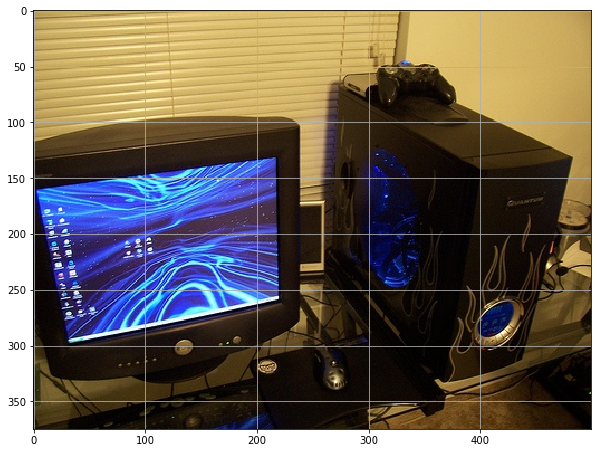

2007_000452.jpg
Elapsed time = 0.280045747756958
[]


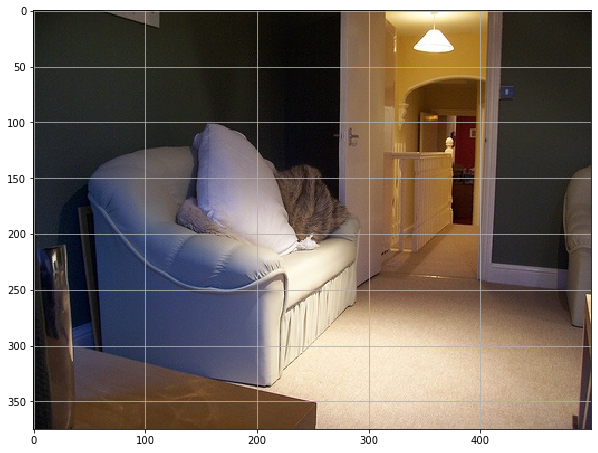

2007_000187.jpg
Elapsed time = 0.27329540252685547
[]


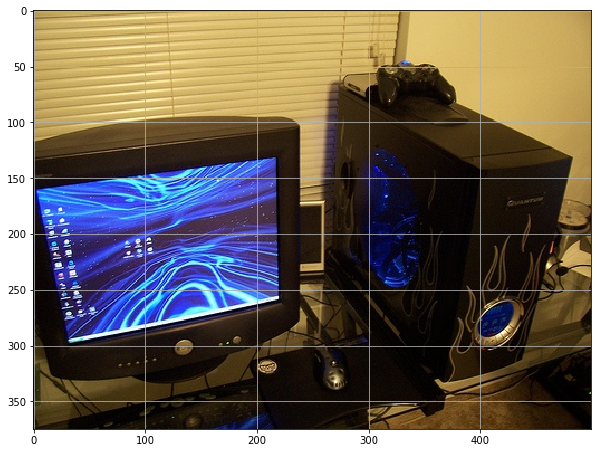

2007_000452.jpg
Elapsed time = 0.28699278831481934
[]


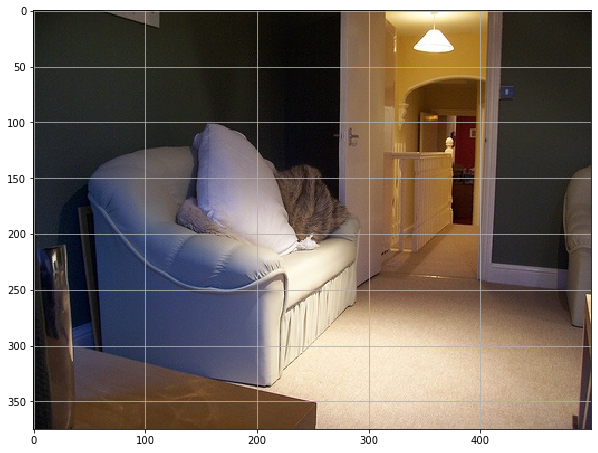

2007_000515.jpg
Elapsed time = 0.2719426155090332
[]


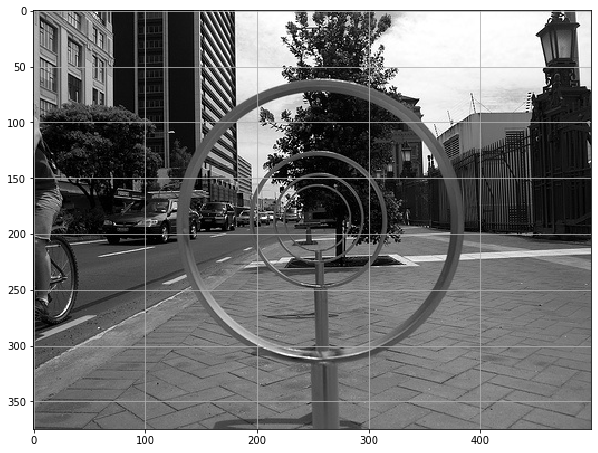

In [38]:
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join("/home/vision/Documents/Rohit/FasterRCNN/Test", img_name)
#     print(filepath)
    img = cv2.imread(filepath)

    X, ratio = format_img(img)
    
    X = np.transpose(X, (0, 2, 3, 1))
    [Y1, Y2, F] = model_rpn.predict(X)
    R = rpn_to_roi(Y1, Y2 , overlap_thresh=0.7)
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}
    for jk in range(R.shape[0]//num_rois + 1):
        ROIs = np.expand_dims(R[num_rois*jk:num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
         # Calculate bboxes coordinates on resized image
#         print(P_cls)
        for ii in range(P_cls.shape[1]):
#             print(ii)
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
#             print(cls_name)
            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([rpn_stride*x, rpn_stride*y, rpn_stride*(x+w), rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

In [37]:
def rpn_to_roi(rpn_layer, regr_layer, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 9) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 36) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / standard_scaling
	anchor_sizes = [64, 128, 256]   # (3 in here)
	anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 9) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [ ]:
for timages in train_imgs:
    img = cv2.imread(timages['filepath'])
    x_img = img.copy()
    (height, width,_) = x_img.shape
    resized_width, resized_height = get_new_img_size(width,height)
    x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
#     calculate rpn
    try:
        downscale = float(rpn_stride) 
        anchor_sizes = [64, 128, 256]   # 128, 256, 512
        anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
        num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

        out_width, out_height = resized_width//16 , resized_height//16
        num_anchor_ratio = len(anchor_ratios) 

        y_rpn_overlap = np.zeros((out_height, out_width, num_anchors))
        y_is_box_valid = np.zeros((out_height, out_width, num_anchors))
        y_rpn_regr = np.zeros((out_height, out_width, num_anchors * 4))
        num_bboxes = len(timages['bboxes'])

        num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
        best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
        best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
        best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
        best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)
        gta = np.zeros((num_bboxes, 4))
#         print(best_iou_for_bbox)
        for bbox_num, bbox in enumerate(timages['bboxes']):
            gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
            gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
            gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
            gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
    #         cv2.rectangle(img,(bbox['x1'],bbox['y1']),(bbox['x2'],bbox['y2']),(255,0,0), 2)
    #         cv2.rectangle(x_img,(int(89*(357/500)),int(129*(357/500))),(int(486*(300/420)),int(351*(300/420))),(255,0,0), 2)
    #         ***********rpn ground truth bobox
        for anchorsize_idx in range(len(anchor_sizes)):
            for anchor_ratio_idx in range(num_anchor_ratio):
                anchor_x = anchor_sizes[anchorsize_idx] * anchor_ratios[anchor_ratio_idx][0]
                anchor_y = anchor_sizes[anchorsize_idx] * anchor_ratios[anchor_ratio_idx][1]
                for ixw in range(out_width):
                    x1_anc = downscale * (ixw + 0.5) - anchor_x / 2
                    x2_anc = downscale * (ixw + 0.5) + anchor_x / 2

                    if x1_anc < 0 or x2_anc > resized_width:
                        continue

                    for jy in range(out_width):
                        y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                        y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                        if y1_anc < 0 or y2_anc > resized_height:
                            continue

                        bbox_type = 'neg'
                        best_iou_for_loc = 0.0

                        for bbox_num in range(num_bboxes):
                            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
    #                         print(curr_iou,best_iou_for_bbox[bbox_num])
                            if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > 0.7:
                                cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                                cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                                cxa = (x1_anc + x2_anc)/2.0
                                cya = (y1_anc + y2_anc)/2.0

                                tx = (cx - cxa) / (x2_anc - x1_anc)
                                ty = (cy - cya) / (y2_anc - y1_anc)
                                tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                                th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                            if timages['bboxes'][bbox_num]['class'] != 'bg':
                                if curr_iou > best_iou_for_bbox[bbox_num]:
                                    best_anchor_for_bbox[bbox_num] = [jy, ixw, anchor_ratio_idx, anchorsize_idx]
                                    best_iou_for_bbox[bbox_num] = curr_iou
                                    best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                    best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]
                                if curr_iou > 0.7:
                                    bbox_type = 'pos'
                                    num_anchors_for_bbox[bbox_num] += 1
    #                                 regressor
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)
                                if 0.3 < curr_iou < 0.7:
                                    if bbox_type != 'pos':
                                        bbox_type = 'neutral'

                        if bbox_type == 'neg':
                            y_is_box_valid[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 1
                            y_rpn_overlap[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 0
                        elif bbox_type == 'neutral':
                            y_is_box_valid[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 0
                            y_rpn_overlap[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 0
                        elif bbox_type == 'pos':
                            y_is_box_valid[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 1
                            y_rpn_overlap[jy, ixw, anchor_ratio_idx + num_anchor_ratio * anchorsize_idx] = 1
                            start = 4 * (anchor_ratio_idx + num_anchor_ratio * anchorsize_idx)
                            y_rpn_regr[jy, ixw, start:start+4] = best_regr
    #         print("y_rpn_overlap ",y_rpn_overlap," y_is_box_valid ",y_is_box_valid," y_rpn_regr ",y_rpn_regr)
        for idx in range(num_anchors_for_bbox.shape[0]):
            if num_anchors_for_bbox[idx] == 0:
                # no box with an IOU greater than zero ...
                if best_anchor_for_bbox[idx, 0] == -1:
                    continue
                y_is_box_valid[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + num_anchor_ratio *best_anchor_for_bbox[idx,3]] = 1
                y_rpn_overlap[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + num_anchor_ratio *best_anchor_for_bbox[idx,3]] = 1
                start = 4 * (best_anchor_for_bbox[idx,2] + num_anchor_ratio * best_anchor_for_bbox[idx,3])
                y_rpn_regr[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]
        y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
        y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

        y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
        y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

        y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
        y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

        pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
        neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

        num_pos = len(pos_locs[0])
    #     set limit
        num_regions = 256

        if len(pos_locs[0]) > num_regions/2:
            val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
            y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
            num_pos = num_regions/2

        if len(neg_locs[0]) + num_pos > num_regions:
            val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
            y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

        y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
        y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

    #     processing image
        x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
        x_img = x_img.astype(np.float32)
        x_img[:, :, 0] -= img_channel_mean[0]
        x_img[:, :, 1] -= img_channel_mean[1]
        x_img[:, :, 2] -= img_channel_mean[2]
        x_img /= 1.0 #image scaling factor set to 1.0

        x_img = np.transpose(x_img, (2, 0, 1))
        x_img = np.expand_dims(x_img, axis=0)
        y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= standard_scaling # standard scaling set to 4.0
        x_img = np.transpose(x_img, (0, 2, 3, 1))
        y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
        y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))
    #     print(x_img.shape)
        input_shape_img = (None, None, 3)
        img_input = Input(shape=input_shape_img)
        roi_input = Input(shape=(None, 4))
    #         shared layers VGG16
        base_layer = base_model_layers(img_input)
        #RPN
        num_anchors = 9
        rpnetwork = rpn(base_layer,num_anchors)
    #         classifier layer 
        classnetwork = classifier(base_layer,roi_input,num_rois,len(classes_count))
        model_rpn = Model(img_input, rpnetwork[:2])
        model_classifier = Model([img_input, roi_input], classnetwork)
        model_all = Model([img_input, roi_input], rpnetwork[:2] + classnetwork)
        optimizer = Adam(lr=1e-5)
        optimizer_classifier = Adam(lr=1e-5)
        model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
        model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
        model_all.compile(optimizer='sgd', loss='mae')
#         print(model_all.summary())
    #         start training
        epoch_length = 10
        num_epochs = 2000 #NUMBER OF EPOCH
        iter_num = 0 
        train_step = 0

        losses = np.zeros((epoch_length, 5))
        rpn_accuracy_rpn_monitor = []
        rpn_accuracy_for_epoch = []
        start_time = time.time()
        best_loss = np.Inf
        print("*** started training ***")
        for epoch in range(num_epochs):
            progbar = generic_utils.Progbar(epoch_length)
            print("Epoch {}/{}".format(epoch+1,num_epochs))
            while True:
                    try:
                        loss_rpn = model_rpn.train_on_batch(np.copy(x_img),[np.copy(y_rpn_cls),np.copy(y_rpn_regr)])
                        P_rpn = model_rpn.predict_on_batch(np.copy(x_img))
                        regr_layer = P_rpn[1] / standard_scaling
                        (rpnrows, rpncols) = P_rpn[0].shape[1:3]
                        curr_layer = 0
                        A = np.zeros((4, P_rpn[0].shape[1], P_rpn[0].shape[2], P_rpn[0].shape[3]))
        #                     A will be of size (4,feature_map_height,feature_map_width,num_anchors) 4 for coordinates num_anchor is 9
                        for anchor_size in anchor_sizes:
                            for anchor_ratio in anchor_ratios:
                                anchor_x = (anchor_size * anchor_ratio[0])/rpn_stride
                                anchor_y = (anchor_size * anchor_ratio[1])/rpn_stride
                                regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
                                regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)
                                X, Y = np.meshgrid(np.arange(rpncols),np.arange(rpnrows))
                                A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
                                A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
                                A[2, :, :, curr_layer] = anchor_x       # width of current anchor
                                A[3, :, :, curr_layer] = anchor_y       # height of current anchor
                                A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)
                                # Avoid width and height to exceed 1
                                A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
                                A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
        #                             convert x ,y, w, h to x1 ,y1 ,x2, y2
                                A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
                                A[3, :, :, curr_layer] += A[1, :, :, curr_layer]
                                A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
                                A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
                                A[2, :, :, curr_layer] = np.minimum(rpncols-1, A[2, :, :, curr_layer])
                                A[3, :, :, curr_layer] = np.minimum(rpnrows-1, A[3, :, :, curr_layer])
                                curr_layer += 1
                        all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))
                        all_probs = P_rpn[0].transpose((0, 3, 1, 2)).reshape((-1))
                        x1 = all_boxes[:, 0]
                        y1 = all_boxes[:, 1]
                        x2 = all_boxes[:, 2]
                        y2 = all_boxes[:, 3]
        #                     delete wrong bounding box
                        idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
                        all_boxes = np.delete(all_boxes, idxs, 0)
                        all_probs = np.delete(all_probs, idxs, 0)
                        result = non_max_suppression_fast(all_boxes, all_probs)[0]
                        X2, Y1, Y2, IouS = calc_iou(result, timages, class_mapping)
                        if X2 is None:
                            rpn_accuracy_rpn_monitor.append(0)
                            rpn_accuracy_for_epoch.append(0)
                            continue
                        neg_samples = np.where(Y1[0, :, -1] == 1)
                        pos_samples = np.where(Y1[0, :, -1] == 0)

                        if len(neg_samples) > 0:
                            neg_samples = neg_samples[0]
                        else:
                            neg_samples = []

                        if len(pos_samples) > 0:
                            pos_samples = pos_samples[0]
                        else:
                            pos_samples = []

                        rpn_accuracy_rpn_monitor.append(len(pos_samples))
                        rpn_accuracy_for_epoch.append((len(pos_samples)))
                        if num_rois > 1:
                            # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                            if len(pos_samples) < num_rois//2:
                                selected_pos_samples = pos_samples.tolist()
                            else:
                                selected_pos_samples = np.random.choice(pos_samples, num_rois//2, replace=False).tolist()

                            # Randomly choose (num_rois - num_pos) neg samples
                            try:
                                selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples), replace=False).tolist()
                            except:
                                selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples), replace=True).tolist()

                            # Save all the pos and neg samples in sel_samples
                            sel_samples = selected_pos_samples + selected_neg_samples
                        else:
                            # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                            selected_pos_samples = pos_samples.tolist()
                            selected_neg_samples = neg_samples.tolist()
                            if np.random.randint(0, 2):
                                sel_samples = random.choice(neg_samples)
                            else:
                                sel_samples = random.choice(pos_samples)
                        loss_class = model_classifier.train_on_batch([np.copy(x_img), X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
                        losses[iter_num, 0] = loss_rpn[1]
                        losses[iter_num, 1] = loss_rpn[2]

                        losses[iter_num, 2] = loss_class[1]
                        losses[iter_num, 3] = loss_class[2]
                        losses[iter_num, 4] = loss_class[3]

                        iter_num += 1
#                         print(losses)
                        progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])), ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
                        if iter_num == epoch_length:
                            loss_rpn_cls = np.mean(losses[:, 0])
                            loss_rpn_regr = np.mean(losses[:, 1])
                            loss_class_cls = np.mean(losses[:, 2])
                            loss_class_regr = np.mean(losses[:, 3])
                            class_acc = np.mean(losses[:, 4])

                            mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                            rpn_accuracy_for_epoch = []
                            
                            print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                            print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                            print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                            print('Loss RPN regression: {}'.format(loss_rpn_regr))
                            print('Loss Detector classifier: {}'.format(loss_class_cls))
                            print('Loss Detector regression: {}'.format(loss_class_regr))
                            print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                            print('Elapsed time: {}'.format(time.time() - start_time))
                            elapsed_time = (time.time()-start_time)/60
                            
                            curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                            iter_num = 0
                            start_time = time.time()

                            if curr_loss < best_loss:
                                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                                best_loss = curr_loss
                                model_all.save_weights(os.path.join('/home/vision/Documents/Rohit/FasterRCNN/model_frcnn_vgg.hdf5'))
                            break

                    except Exception as e:
                        print("training error {}".format(e))
                        continue
        
    except  Exception as e:
        print(e)
        continue
    
#     break
    
print("Training completed")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
{'filepath': '/home/vision/Documents/Rohit/RCNN/VOC2012/JPEGImages/2008_003585.jpg', 'width': 500, 'height': 375, 'bboxes': [{'class': 'tvmonitor', 'x1': 1, 'x2': 297, 'y1': 24, 'y2': 325, 'difficult': False}], 'image_id': 2526, 'imageset': 'train'}


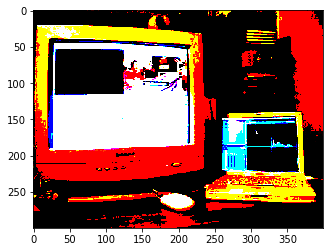

In [136]:
for i in range(5):
    y = next(data)
    plt.imshow(y[0][0,:, :, :])
    print(len(y[1]))
    print(y[2])
    break

In [117]:
def augment(img_data, augment=''):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if False and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if False and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if False:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

In [7]:
!nvidia-smi

Wed Sep 11 19:14:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.87                 Driver Version: 390.87                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
| 65%   74C    P2   240W / 250W |   6375MiB / 11178MiB |     48%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  